This notebook uses the `develop` branch of `darts`, in order to take advantage of model re-training

In [1]:
import sys

import matplotlib.pyplot as plt
import json

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

# try:
#     from private.lyap import lyap_r, lyap_e, corr_dim
# except:
#     from nolds import lyap_r, lyap_e, corr_dim

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:

for equation_name in equation_data.dataset:
    
    print(equation_name, flush=True)

    with open(output_path, 'w') as f:
        json.dump(all_hyperparameters, f, indent=4)   

In [ ]:
## Define a model that predicts a time series, given its previous values


import pandas as pd
from scipy.signal import savgol_filter

import darts 
from darts import TimeSeries
from darts.models import RNNModel

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error


try:
    del model
except:
    pass

full_epoch_count = 400
forecast_length = 200

hyperparams = {"input_chunk_length": 50, "output_chunk_length": 1, "model": "LSTM", "n_rnn_layers": 2}
model = RNNModel(**hyperparams)


from dysts.flows import Lorenz
equation = Lorenz()
sol = equation.make_trajectory(1200, resample=True)
y_train, y_test = sol[:-forecast_length, 0], sol[-forecast_length:, 0]




# hyperparams = {"input_chunk_length": 50, "output_chunk_length": 1}
# model = NBEATSModel(**hyperparams)

y_train_ts = TimeSeries.from_dataframe(pd.DataFrame(y_train))


model.fit(y_train_ts, epochs=full_epoch_count)
# for i in range(10):
#     model.fit(y_train_ts)
y_val_pred = model.predict(forecast_length)
y_val_pred = np.squeeze(y_val_pred.values())


## Show results
plt.plot(y_test)
plt.plot(y_val_pred)

## Find worst-performing points



print(mean_absolute_percentage_error(y_test, y_val_pred, symmetric=True))

[2021-06-29 23:26:01,954] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.
[2021-06-29 23:26:01,954] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.


In [ ]:
def adversarial_training(model, traj, n_iters, epochs_per_iter, samples_per_iter):
    """
    model (darts.model): A dynamical system model
    traj (np.ndarray): A T x D trajectory of the dynamical system
    """
    sol = equation.make_trajectory(1000, resample=True)
    for i in range(n_iters):
        y_train_backtest = y_train_ts.values()[-len(pred_backtest):]
        # plt.plot(smape_indexwise(pred_backtest, y_train_backtest))
        mse_back = np.squeeze(np.sqrt((pred_backtest - y_train_backtest)**2))
        sample_probs = savgol_filter(mse_back, 21, 3)
        sample_probs[sample_probs<0] = 0
        sample_probs /= np.sum(sample_probs)


        ic_indices = np.random.choice(np.arange(len(y_train_backtest)), n_ic, p=sample_probs, replace=True)
        # ic_indices = np.random.choice(np.arange(len(y_train_backtest)), n_ic)

        ic_vals = sol[ic_indices] + 1e-3 * (np.random.random(sol[ic_indices].shape) - 0.5)
        equation.ic = ic_vals
        new_sol = equation.make_trajectory(1000, resample=True)
        y_train_list = list(new_sol[..., 0])
        y_train_list = [TimeSeries.from_dataframe(pd.DataFrame(item)) for item in y_train_list]
        model.fit(y_train_ts, epochs=epoch_count)
        pred_backtest = model.historical_forecasts(y_train_ts, retrain=False, start=(1 + model.input_chunk_length)).values()
    
    return model

In [ ]:


n_iters = 5
epoch_count = 10
n_ic = full_epoch_count// (n_iters * epoch_count)  # model retraining is not currently working in darts
print(f"{n_ic} points sampled per iteration, for a total of {n_iters} iterations of length {epoch_count}")

pred_backtest = model.historical_forecasts(y_train_ts, retrain=False, start=(1 + model.input_chunk_length)).values()
# model = RNNModel(50, 1, model="LSTM", n_rnn_layers=2, n_epochs=epoch_count)
model = RNNModel(**hyperparams)
# model = NBEATSModel(**hyperparams)
sol = equation.make_trajectory(1000, resample=True)
for i in range(n_iters):
    print(i)
    
    y_train_backtest = y_train_ts.values()[-len(pred_backtest):]
    # plt.plot(smape_indexwise(pred_backtest, y_train_backtest))
    mse_back = np.squeeze(np.sqrt((pred_backtest - y_train_backtest)**2))
    sample_probs = savgol_filter(mse_back, 21, 3)
    sample_probs[sample_probs<0] = 0
    sample_probs /= np.sum(sample_probs)


    ic_indices = np.random.choice(np.arange(len(y_train_backtest)), n_ic, p=sample_probs, replace=True)
    # ic_indices = np.random.choice(np.arange(len(y_train_backtest)), n_ic)

    ic_vals = sol[ic_indices] + 1e-3 * (np.random.random(sol[ic_indices].shape) - 0.5)
    equation.ic = ic_vals
    new_sol = equation.make_trajectory(1000, resample=True)
    y_train_list = list(new_sol[..., 0])
    y_train_list = [TimeSeries.from_dataframe(pd.DataFrame(item)) for item in y_train_list]
    model.fit(y_train_ts, epochs=epoch_count)
    pred_backtest = model.historical_forecasts(y_train_ts, retrain=False, start=(1 + model.input_chunk_length)).values()

y_val_pred = model.predict(forecast_length)
y_val_pred = np.squeeze(y_val_pred.values())


## Show results
plt.plot(y_test)
plt.plot(y_val_pred)

print(mean_absolute_percentage_error(y_test, y_val_pred, symmetric=True))

In [ ]:
0.5482721423192519

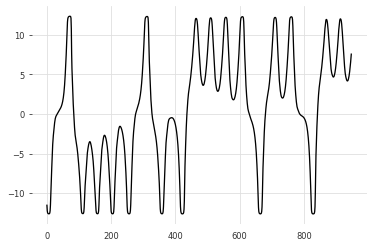

In [69]:
plt.plot(pred_backtest)

In [ ]:
ForcedFitzHughNagumo

+ sample new ic along bad directions

Compute jacobian of trajectories, and sample along direction of LLE


In [111]:
y_train_list[0].shape

(1000,)

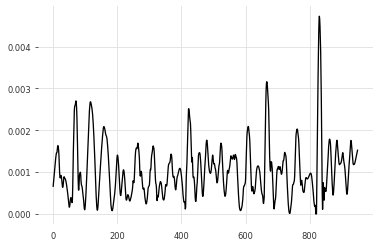

In [89]:


plt.plot(sample_probs)

In [13]:
# ?model.historical_forecasts

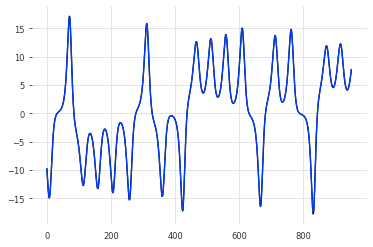

In [27]:
plt.plot(y_train_backtest)
plt.plot(pred_backtest)